# 1. 최종 XGBoost 모델 학습

## 1) 최종 피처 불러오기

In [8]:
import joblib
final_features = joblib.load("../data/processed/final_features.pkl")
print(f"불러온 변수 개수: {len(final_features)}")
print(final_features)

불러온 변수 개수: 31
['avg_pay_grp_std', 'cancel_rate_grp_std', 'cust_cnt_grp_last', 'female_20below_ratio_mean', 'female_50_ratio_last', 'female_50_ratio_std', 'female_60plus_ratio_std', 'is_customer_missing_mean', 'male_30_ratio_std', 'male_50_ratio_mean', 'male_50_ratio_std', 'male_60plus_ratio_last', 'male_60plus_ratio_mean', 'new_ratio_mean', 'rel_sales_ratio_last', 'rel_sales_ratio_mean', 'rel_txn_ratio_last', 'rel_txn_ratio_mean', 'resident_ratio_mean', 'revisit_ratio_last', 'revisit_ratio_std', 'sales_grp_std', 'sales_rank_industry_last', 'sales_rank_industry_std', 'sales_rank_market_last', 'sales_rank_market_std', 'share_sales_industry_mean', 'share_sales_industry_std', 'share_sales_market_mean', 'share_sales_market_std', 'txn_cnt_grp_std']


 X_Train shape: (40856, 31)
 X_Test shape: (11772, 31)
R²: 0.796
MAE: 34.989


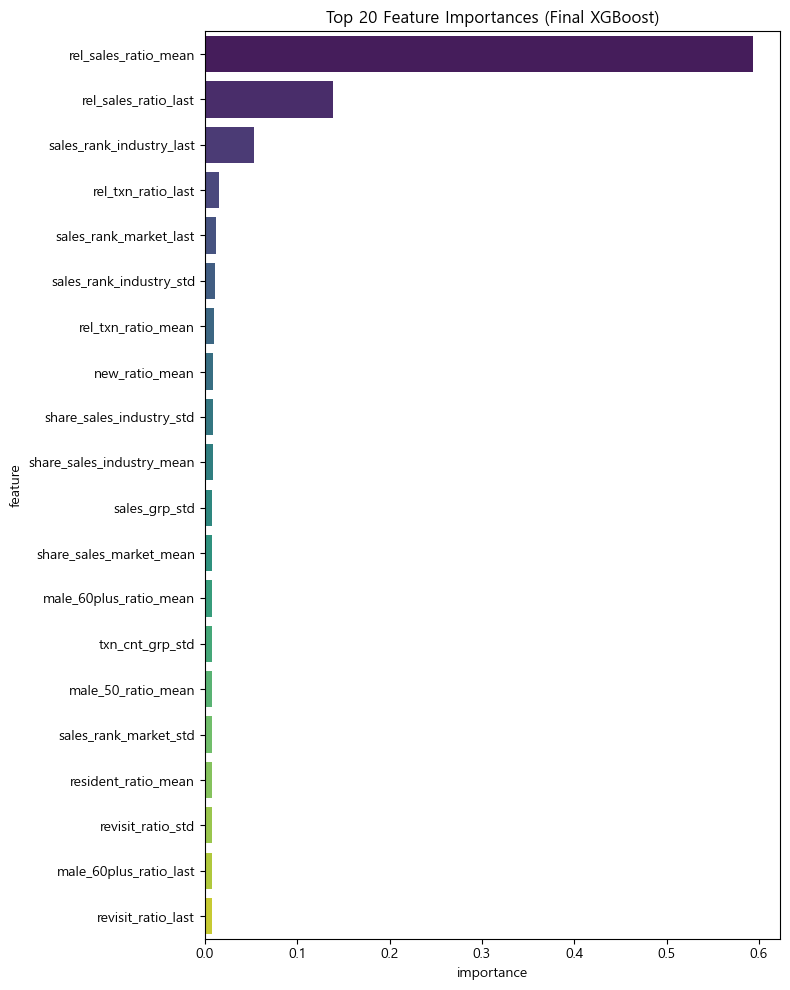

In [9]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

train = pd.read_csv("../data/processed/train_sliding.csv")
test = pd.read_csv("../data/processed/test_sliding.csv")
drop_cols = ['num', 'base_ym', 'target_ym', 'open', 'y']

X_train = train.drop(columns=drop_cols, errors='ignore')[final_features]
X_test = test.drop(columns=drop_cols, errors='ignore')[final_features]
y_train = train['y']
y_test = test['y']
print(" X_Train shape:", X_train.shape)
print(" X_Test shape:", X_test.shape)


# 모델 정의 및 학습
xgb_final = XGBRegressor(
    n_estimators=500, learning_rate=0.03, max_depth=7,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)
xgb_final.fit(X_train, y_train)

# 예측
y_pred = xgb_final.predict(X_test)

# 성능 확인
print("R²:", round(r2_score(y_test, y_pred), 3))
print("MAE:", round(mean_absolute_error(y_test, y_pred), 3))

# Feature Importance 시각화
imp = pd.DataFrame({
    'feature': final_features,
    'importance': xgb_final.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(data=imp.head(20), x='importance', y='feature', palette='viridis')
plt.title("Top 20 Feature Importances (Final XGBoost)")
plt.tight_layout()
plt.show()


## 2) 베이스라인 모델 성능 확인

In [10]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

base_model = XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)
base_model.fit(X_train, y_train)

y_pred = base_model.predict(X_test)
print("📊 [Baseline]")
print("R²:", round(r2_score(y_test, y_pred), 4))
print("MAE:", round(mean_absolute_error(y_test, y_pred), 4))


📊 [Baseline]
R²: 0.7941
MAE: 35.1041


## 3) 하이퍼파라미터 튜닝 & 최적 파라미터 도출

In [11]:
# RandomizedSearchCV로 빠른 1차 튜닝
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [200, 400, 600, 800],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [4, 6, 8, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3]
}

xgb_model = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=30,              # 탐색 횟수 (속도 조절 가능)
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("\n✅ Best Params:")
print(random_search.best_params_)
print("Best CV MAE:", -random_search.best_score_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits

✅ Best Params:
{'subsample': 0.6, 'n_estimators': 800, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.6}
Best CV MAE: 32.64526315747698


In [12]:
# 최적 파라미터로 재학습
best_params = random_search.best_params_

xgb_tuned = XGBRegressor(
    **best_params,
    random_state=42
)
xgb_tuned.fit(X_train, y_train)

y_pred_tuned = xgb_tuned.predict(X_test)

print("\n📊 [Tuned Model Performance]")
print("R²:", round(r2_score(y_test, y_pred_tuned), 4))
print("MAE:", round(mean_absolute_error(y_test, y_pred_tuned), 4))



📊 [Tuned Model Performance]
R²: 0.7959
MAE: 34.8382


In [13]:
# 신규점/ 기존점별 성능 평가
from sklearn.metrics import mean_absolute_error, r2_score

# 기존점 / 신규점 구분
is_cold = test['is_cold_start'].values.astype(int)

# 전체 예측 성능
print("\n📊 [Tuned Model Performance - Overall]")
print("R² :", round(r2_score(y_test, y_pred_tuned), 4))
print("MAE:", round(mean_absolute_error(y_test, y_pred_tuned), 4))

# 기존점(Cold Start = 0)
mask_existing = (is_cold == 0)
r2_existing = r2_score(y_test[mask_existing], y_pred_tuned[mask_existing])
mae_existing = mean_absolute_error(y_test[mask_existing], y_pred_tuned[mask_existing])

# 신규점(Cold Start = 1)
mask_new = (is_cold == 1)
r2_new = r2_score(y_test[mask_new], y_pred_tuned[mask_new])
mae_new = mean_absolute_error(y_test[mask_new], y_pred_tuned[mask_new])

print("\n🔹 [기존 가맹점 성능]")
print(f"R² : {r2_existing:.4f}")
print(f"MAE: {mae_existing:.4f}")

print("\n🔸 [신규 가맹점 성능]")
print(f"R² : {r2_new:.4f}")
print(f"MAE: {mae_new:.4f}")

print("\n✅ 신규점 비율:", mask_new.mean())



📊 [Tuned Model Performance - Overall]
R² : 0.7959
MAE: 34.8382

🔹 [기존 가맹점 성능]
R² : 0.7990
MAE: 34.5146

🔸 [신규 가맹점 성능]
R² : 0.7479
MAE: 39.3115

✅ 신규점 비율: 0.06744818212708122


---

# 2. 원인 분석 & Rule-Based 리포트 생성

## 1) Rule-Based 텍스트 원인 분석 + 솔루션 생성

In [14]:
import pandas as pd
import numpy as np

# =========================
# 1. Feature label map
# =========================
LABELS = {
    'avg_pay_grp_std':'객단가 변동성',
    'cancel_rate_grp_std':'취소율 변동성',
    'cust_cnt_grp_last':'최근 고객수',
    'revisit_ratio_last':'최근 재방문율',
    'revisit_ratio_std':'재방문율 변동성',
    'new_ratio_mean':'신규고객 비율',
    'resident_ratio_mean':'거주 고객 비율',
    'rel_sales_ratio_mean':'업종대비 매출비율(평균)',
    'rel_sales_ratio_last':'업종대비 매출비율(최근)',
    'rel_txn_ratio_mean':'거래비율(평균)',
    'rel_txn_ratio_last':'거래비율(최근)',
    'sales_grp_std':'매출 변동성',
    'sales_rank_market_std':'상권내 순위 변동성',
    'sales_rank_market_last':'상권내 순위(최근)',
    'sales_rank_industry_std':'업종내 순위 변동성',
    'sales_rank_industry_last':'업종내 순위(최근)',
    'share_sales_market_mean':'상권내 매출 점유율(평균)',
    'share_sales_market_std':'상권내 매출 점유율 변동성',
    'share_sales_industry_mean':'업종내 매출 점유율(평균)',
    'share_sales_industry_std':'업종내 매출 점유율 변동성',
    'male_50_ratio_mean':'남성50대 비중(평균)',
    'male_50_ratio_std':'남성50대 비중 변동성',
    'male_60plus_ratio_last':'남성60+ 비중(최근)',
    'male_60plus_ratio_mean':'남성60+ 비중(평균)',
    'male_30_ratio_std':'남성30대 비중 변동성',
    'female_20below_ratio_mean':'여성20↓ 비중(평균)',
    'female_50_ratio_last':'여성50대 비중(최근)',
    'female_50_ratio_std':'여성50대 비중 변동성',
    'female_60plus_ratio_std':'여성60+ 비중 변동성',
    'is_customer_missing_mean':'고객데이터 결측비율(평균)',
    'txn_cnt_grp_std':'거래건수 변동성',
}

def _label(k): return LABELS.get(k, k)

# =========================
# 2. Rule-based Action Templates
# =========================
RULES = {
    # -------------------------------
    # 1. 매출 및 거래 관련
    # -------------------------------
    "avg_pay_grp_std": {
        "neg": "객단가 변동성이 커져 매출 구조가 불안정하며 업종 내 점유율 하락 위험이 있습니다.",
        "actions": [
            "가격대별 판매 비중을 점검하고 중간 가격대 상품을 강화하세요.",
            "고객이 일관된 지출을 할 수 있도록 프로모션 및 메뉴 구성을 단순화하세요."
        ]
    },
    "cancel_rate_grp_std": {
        "neg": "취소율이 불안정하여 실제 매출 실현률이 낮아지고 있습니다.",
        "actions": [
            "배달 및 예약 취소 사유를 분석하고 품절·지연 발생을 줄이세요.",
            "고객 불만 원인을 개선하고 재구매율을 높일 대응 프로세스를 만드세요."
        ]
    },
    "txn_cnt_grp_std": {
        "neg": "거래건수의 변동성이 높아 일관된 매출 확보가 어려운 상태입니다.",
        "actions": [
            "요일·시간대별 거래건수 패턴을 분석해 저조 시간대 집중 프로모션을 운영하세요.",
            "정기 방문 고객을 확보하기 위해 구독형/포인트 적립 프로그램을 검토하세요."
        ]
    },
    "sales_grp_std": {
        "neg": "월별 매출 변동성이 높아 업종 내 매출 점유율 유지가 어렵습니다.",
        "actions": [
            "성수기·비수기 매출 차이를 완화할 수 있는 프로모션을 설계하세요.",
            "고객 충성도를 높여 매출을 평탄화하세요."
        ]
    },

    # -------------------------------
    # 2. 업종·상권 내 점유율 / 순위
    # -------------------------------
    "sales_rank_industry_last": {
        "neg": "최근 업종 내 매출 비중이 하락하여 경쟁력이 약화되었습니다.",
        "actions": [
            "동일 업종 내 상위 점포의 인기 상품 및 가격 정책을 벤치마킹하세요.",
            "리뷰 관리 및 재방문율 개선으로 업종 내 인지도를 높이세요."
        ]
    },
    "sales_rank_industry_std": {
        "neg": "업종 내 매출 비중의 변동성이 커져 점유율 안정성이 낮습니다.",
        "actions": [
            "시즌별 판매 추이를 점검해 변동성이 큰 품목의 재고·가격 전략을 보완하세요.",
            "장기적으로는 주력 상품군을 명확히 하여 점유율을 안정화하세요."
        ]
    },
    "sales_rank_market_last": {
        "neg": "상권 내 매출 비중이 하락해 고객 유입이 감소하는 추세입니다.",
        "actions": [
            "상권 내 경쟁점의 이벤트·리뷰·운영시간을 분석해 대응 전략을 세우세요.",
            "주력 고객층(연령·성별)에 맞는 맞춤형 할인이나 패키지 상품을 기획하세요."
        ]
    },
    "sales_rank_market_std": {
        "neg": "상권 내 매출 비중 변동성이 커져 예측이 어렵고 안정성이 낮습니다.",
        "actions": [
            "주말·평일 간 매출 편차를 줄이는 프로모션을 검토하세요.",
            "매출 집중 시간대에 맞춰 인력 및 재고를 최적화하세요."
        ]
    },
    "share_sales_industry_mean": {
        "neg": "업종 내 평균 매출 점유율이 낮아 경쟁력이 약화되고 있습니다.",
        "actions": [
            "동일 업종 내 인기 상품군을 분석해 가격·품질 경쟁력을 확보하세요.",
            "고객 재방문 혜택을 강화해 점유율을 높이세요."
        ]
    },
    "share_sales_industry_std": {
        "neg": "업종 내 매출 점유율 변동성이 높아 시장 내 위치가 불안정합니다.",
        "actions": [
            "주요 매출 품목의 안정적 공급망을 확보하세요.",
            "시즌/이벤트 의존도를 낮추고 꾸준한 매출 품목을 발굴하세요."
        ]
    },
    "share_sales_market_mean": {
        "neg": "상권 내 매출 점유율이 낮아 고객 유입이 감소하고 있습니다.",
        "actions": [
            "상권 내 고객층 특성(연령·시간대)에 맞는 프로모션을 기획하세요.",
            "오프라인 간판·온라인 리뷰 노출을 동시에 강화하세요."
        ]
    },
    "share_sales_market_std": {
        "neg": "상권 내 매출 점유율 변동성이 높아 수요 예측이 어렵습니다.",
        "actions": [
            "주요 요일/시간대 매출 데이터를 점검하여 패턴을 안정화하세요.",
            "리뷰 이벤트나 정기 혜택을 통해 충성 고객 비중을 높이세요."
        ]
    },

    # -------------------------------
    # 3. 고객 관련
    # -------------------------------
    "cust_cnt_grp_last": {
        "neg": "최근 방문 고객 수가 감소하여 매출 점유율이 하락하고 있습니다.",
        "actions": [
            "SNS 채널이나 지역 커뮤니티 홍보를 강화해 신규 고객 유입을 확대하세요.",
            "기존 고객 재방문을 유도하는 쿠폰·포인트 제도를 운영하세요."
        ]
    },
    "revisit_ratio_last": {
        "neg": "재방문율 하락으로 단골 고객 기반이 약화되고 있습니다.",
        "actions": [
            "단골 고객 대상 멤버십 쿠폰 또는 스탬프 이벤트를 운영하세요.",
            "리뷰 이벤트나 단골 전용 혜택으로 재방문을 유도하세요."
        ]
    },
    "revisit_ratio_std": {
        "neg": "재방문율의 변동이 커 고객 충성도가 불안정합니다.",
        "actions": [
            "방문 주기 데이터를 분석해 최적의 리마케팅 시점을 설정하세요.",
            "일관된 고객 경험(서비스·품질)을 유지하세요."
        ]
    },
    "new_ratio_mean": {
        "neg": "신규 고객 유입이 둔화되어 업종 내 매출비중이 줄고 있습니다.",
        "actions": [
            "SNS 광고·지역 커뮤니티 노출을 강화하세요.",
            "첫 방문 고객 대상 할인 또는 체험 이벤트를 기획하세요."
        ]
    },
    "resident_ratio_mean": {
        "neg": "거주 고객 비중이 낮아 상권 내 안정적 수요 확보가 어렵습니다.",
        "actions": [
            "인근 아파트·오피스 대상 지역 마케팅을 강화하세요.",
            "정기 배달/픽업 프로그램을 운영해 거주 고객을 고정 수요로 전환하세요."
        ]
    },
    "is_customer_missing_mean": {
        "neg": "고객 데이터 결측이 많아 주요 고객층 특성을 파악하기 어렵습니다.",
        "actions": [
            "POS·배달앱 등에서 고객 속성 데이터를 점검하고 누락을 최소화하세요.",
            "데이터 기반 마케팅을 위해 회원가입·적립률을 높이세요."
        ]
    },

    # -------------------------------
    # 4. 인구통계 (성별·연령)
    # -------------------------------
    "male_30_ratio_std": {
        "neg": "남성 30대 비중이 불안정하여 주요 고객층 매출이 흔들리고 있습니다.",
        "actions": [
            "남성 30대 선호 상품군(간편식, 커피 등)의 프로모션을 진행하세요.",
            "주요 방문 시간대를 분석해 피크 타임 집중 캠페인을 설계하세요."
        ]
    },
    "male_50_ratio_mean": {
        "neg": "남성 50대 고객 비중이 낮아 핵심 소비층 매출이 감소하고 있습니다.",
        "actions": [
            "가족·중장년층 대상 패키지 또는 식사 프로모션을 진행하세요.",
            "편의성 높은 결제·예약 기능을 강화해 이용 접근성을 높이세요."
        ]
    },
    "male_50_ratio_std": {
        "neg": "남성 50대 고객 비중이 불안정해 매출 예측 정확도가 떨어집니다.",
        "actions": [
            "요일·시간대별 이용 패턴을 분석하고 맞춤형 이벤트를 기획하세요.",
            "중장년층 타깃 SNS/오프라인 홍보를 병행하세요."
        ]
    },
    "male_60plus_ratio_last": {
        "neg": "최근 남성 60세 이상 고객 매출 비중이 하락했습니다.",
        "actions": [
            "시니어층 선호 메뉴·서비스를 강화하세요.",
            "장년층이 편리하게 접근할 수 있는 위치·시간대를 활용하세요."
        ]
    },
    "male_60plus_ratio_mean": {
        "neg": "평균적으로 남성 60세 이상 고객 비중이 낮아 매출 기여도가 약합니다.",
        "actions": [
            "시니어층 전용 혜택(커피 할인, 포인트 적립)을 마련하세요.",
            "근처 의료·공공시설과 연계한 공동 이벤트를 검토하세요."
        ]
    },
    "female_20below_ratio_mean": {
        "neg": "여성 20대 이하 고객 비중이 낮아 트렌드 고객 유입이 약합니다.",
        "actions": [
            "SNS·인플루언서 마케팅을 활용해 젊은층 관심도를 높이세요.",
            "시즌 한정 상품이나 포토존 이벤트로 참여를 유도하세요."
        ]
    },
    "female_50_ratio_last": {
        "neg": "최근 여성 50대 고객 매출 비중이 하락했습니다.",
        "actions": [
            "중년층 여성 고객의 구매 패턴에 맞는 건강·편의 상품을 강화하세요.",
            "리뷰/추천 기반 판촉으로 신뢰를 높이세요."
        ]
    },
    "female_50_ratio_std": {
        "neg": "여성 50대 고객 비중이 불안정하여 매출 예측이 어렵습니다.",
        "actions": [
            "이 연령대가 많이 찾는 시간대/요일 중심으로 운영을 최적화하세요.",
            "정기 방문 혜택을 제공해 충성도를 높이세요."
        ]
    },
    "female_60plus_ratio_std": {
        "neg": "여성 60세 이상 고객 비중이 불안정하여 안정적 매출 확보가 어렵습니다.",
        "actions": [
            "시니어 여성층 맞춤 혜택(디저트, 차류 할인 등)을 기획하세요.",
            "지역 커뮤니티 연계 이벤트로 인지도를 높이세요."
        ]
    },

    # -------------------------------
    # 5. 상대적 매출·거래 비율
    # -------------------------------
    "rel_sales_ratio_last": {
        "neg": "최근 업종 대비 매출 비중이 하락했습니다.",
        "actions": [
            "업종 내 상위 매장의 주요 판매 품목·가격대를 분석하세요.",
            "신규 메뉴 또는 시즌 한정 상품으로 관심도를 높이세요."
        ]
    },
    "rel_sales_ratio_mean": {
        "neg": "최근 3개월 평균 업종 대비 매출 비중이 낮은 상태입니다.",
        "actions": [
            "동종 업종 평균 대비 가격/품질 경쟁력을 점검하세요.",
            "고객 리뷰나 광고 노출을 통해 브랜드 인지도를 높이세요."
        ]
    },
    "rel_txn_ratio_last": {
        "neg": "최근 업종 대비 거래건수 비중이 낮아 수요가 감소 중입니다.",
        "actions": [
            "시간대별 방문 데이터를 분석하고 피크 타임 집중 마케팅을 진행하세요.",
            "거래건수 증대를 위한 소액결제·간편구매 프로모션을 검토하세요."
        ]
    },
    "rel_txn_ratio_mean": {
        "neg": "최근 3개월간 업종 대비 거래건수 비중이 지속적으로 낮은 편입니다.",
        "actions": [
            "주요 고객층을 재정의하고 타깃 맞춤형 상품을 강화하세요.",
            "주중·주말 간 이용 패턴을 분석해 최적의 영업 전략을 세우세요."
        ]
    },
}


# =========================
# 3. Core Function
# =========================
def generate_shop_report(idx, model, explainer, X_df, test_df, train_df, final_features):
    """
    SHAP 기반 점포별 원인 + 솔루션 리포트
    - 위험등급(Rule)
    - SHAP Top±3 요인
    - Rule-based Action
    - 최근 3개월 y 추이 (train+test 기반)
    """
    import numpy as np
    import pandas as pd

    # 1️⃣ 안전한 타깃 컬럼 인식
    tgt = 'y' if 'y' in test_df.columns else 'y_next_rank'
    row_x = X_df.iloc[[idx]]
    y_true = float(test_df.iloc[idx][tgt])
    y_pred = float(model.predict(row_x)[0])
    num = test_df.iloc[idx]['num'] if 'num' in test_df.columns else idx
    target_ym = test_df.iloc[idx]['target_ym'] if 'target_ym' in test_df.columns else None

    # =========================
    # 2️⃣ 지난 3개월 y 추이 (train+test 기반)
    # =========================
    # full_df = train + test 합쳐서 y 비교
    full_df = pd.concat([train_df, test_df], ignore_index=True)

    # target_ym 비교가 잘 되도록 datetime 변환
    full_df['target_ym_dt'] = pd.to_datetime(full_df['target_ym'], errors='coerce')
    target_dt = pd.to_datetime(target_ym, errors='coerce')



    hist = (
        full_df[(full_df['num'] == num) & (full_df['target_ym_dt'] < target_dt)]
        .sort_values('target_ym_dt')
        .tail(3)
    )
    hist_y = hist[tgt].tolist()
    trend_text = ""

    if len(hist_y) > 0:
        mean3 = np.mean(hist_y)
        direction = "상승" if y_pred > mean3 else "하락"
        diff = y_pred - mean3
        trend_text = (
            f"지난 3개월 평균({mean3:.1f}) 대비 다음 달 예측은 {direction} 추세입니다. "
            f"(예측값 {y_pred:.1f}, 변화폭 {diff:+.1f})"
        )
    else:
        if 'is_cold_start' in test_df.columns and test_df.loc[idx, 'is_cold_start'] == 1:
            trend_text = "신규 오픈 매장으로, 지난 3개월 실적 데이터가 없습니다."
        else:
            trend_text = "이전 3개월 실적 데이터가 누락되어 추이 비교가 불가능합니다."

    # =========================
    # 3️⃣ SHAP 기여도 분석
    # =========================
    shap_vals = explainer.shap_values(row_x)[0]
    contrib = pd.DataFrame({'feature': final_features, 'shap': shap_vals})
    contrib['abs'] = contrib['shap'].abs()
    contrib = contrib.sort_values('abs', ascending=False)
    top_pos = contrib.sort_values('shap', ascending=False).head(3)
    top_neg = contrib.sort_values('shap', ascending=True).head(3)

    # =========================
    # 4️⃣ 위험등급 Rule
    # =========================
    if y_pred < 40:
        risk = "🔴 High Risk"
    elif y_pred < 60:
        risk = "🟠 Medium Risk"
    else:
        risk = "🟢 Stable"

    # =========================
    # 5️⃣ 솔루션 생성 (RULES 사전은 기존 그대로 사용)
    # =========================
    solutions = []
    for _, row in top_neg.iterrows():
        feat = row['feature']
        if feat in RULES:
            rule = RULES[feat]
            txt = f"- {_label(feat)}: {rule['neg']}\n  ▶ {' / '.join(rule['actions'])}"
            solutions.append(txt)
        else:
            solutions.append(f"- {_label(feat)}: 부정적 영향 요인으로 분석됨(추가 분석 필요)")

    # =========================
    # 6️⃣ 최종 텍스트 리포트 생성
    # =========================
    report = f"""
📍 가맹점 {num} | 대상월: {target_ym}
예측값: {y_pred:.2f} (실제: {y_true:.2f}) | 위험등급: {risk}

📊 최근 3개월 추이
  {trend_text}
  지난 3개월 y 값: {hist_y if len(hist_y) > 0 else '데이터 없음'}

🔍 SHAP 기반 주요 요인
  + 긍정요인(+): {', '.join([_label(f) for f in top_pos['feature']])}
  - 부정요인(–): {', '.join([_label(f) for f in top_neg['feature']])}

💡 개선 솔루션 제안
{chr(10).join(solutions)}
""".strip()

    return {
        "num": num,
        "target_ym": target_ym,
        "y_true": y_true,
        "y_pred": y_pred,
        "risk": risk,
        "trend_text": trend_text,
        "report": report
    }



## 2) 리뷰 통합 리포트

In [17]:
df_info = pd.read_csv("../data/raw/big_data_set1_f.csv", encoding="cp949")

In [18]:
import time
import pandas as pd
import numpy as np
import re
import os
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from openai import OpenAI
from dotenv import load_dotenv

# ============================================================
# 0️⃣ 환경 설정
# ============================================================
load_dotenv()  # .env 파일에서 OPENAI_API_KEY 로드
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# ============================================================
# 1️⃣ 리뷰 마스킹 해제 함수
# ============================================================
def extract_unmasked_name(masked_name: str) -> str:
    """
    마스킹된 상호명(MCT_NM)에서 '*'을 제외한 실제 문자열만 추출
    예: '케이***' → '케이', '호남*' → '호남'
    """
    if not isinstance(masked_name, str):
        return ""
    # '*' 및 공백 제거
    unmasked = re.sub(r"[*\s]+", "", masked_name)
    return unmasked.strip()

# ============================================================
# 2️⃣ 네이버 리뷰 수집 함수 (디버깅 로그 포함)
# ============================================================
def get_reviews_from_naver(address, category, masked_name, max_reviews=10, debug=True):
    """
    주소 + 업종 + (MCT_NM의 비마스킹된 이름) 기반 네이버 지도 리뷰 수집
    예: '서울 성동구 마장동 한식-육류/고기 호남'
    """
    try:
        unmasked_name = extract_unmasked_name(masked_name)
        if debug:
            print(f"[0] 함수 시작 - address: {address}, category: {category}, masked_name: {masked_name}, unmasked_name: {unmasked_name}")

        # --- 검색어 구성 ---
        if unmasked_name:
            query = f"{address} {category} {unmasked_name}"
        else:
            query = f"{address} {category}"
        query = query.strip()

        # --- 네이버 지도 접속 ---
        options = Options()
        options.add_argument("--headless")
        options.add_argument("--disable-blink-features=AutomationControlled")
        options.add_argument("--no-sandbox")

        if debug: print("[1] Chrome 드라이버 실행 중...")
        driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
        driver.get("https://map.naver.com/p")
        time.sleep(2)

        # --- 검색 수행 ---
        search_box = driver.find_element(By.CLASS_NAME, "input_search")
        search_box.send_keys(query)
        search_box.send_keys(Keys.ENTER)
        if debug: print(f"[2] 검색어 입력 완료 → {query}")
        time.sleep(3)

        # --- 결과 탐색 ---
        results = driver.find_elements(By.CSS_SELECTOR, "button.link_space")
        if debug: print(f"[3] 검색 결과 {len(results)}건 발견")

        matched = None
        for r in results:
            try:
                name = r.find_element(By.CSS_SELECTOR, "strong.space_title").text.strip()
                if unmasked_name and (name.startswith(unmasked_name) or unmasked_name in name):
                    matched = r
                    if debug: print(f"[4] ✅ 일치하는 가게 찾음: {name}")
                    break
            except Exception as e:
                if debug: print(f"[4-ERR] 비교 중 오류: {e}")
                continue

        if matched is None:
            print("❌ [FAIL] 조건에 맞는 가게를 찾지 못했습니다.")
            driver.quit()
            return None

        # --- 상세페이지 이동 + 리뷰탭 클릭 ---
        matched.click()
        time.sleep(3)
        driver.switch_to.frame("entryIframe")
        if debug: print("[5] 상세 페이지 iframe 진입 완료")

        wait = WebDriverWait(driver, 15)
        review_tab = wait.until(
            EC.element_to_be_clickable((By.XPATH, "//a[contains(@class,'_tab-menu')]//span[text()='리뷰']"))
        )
        review_tab.click()
        if debug: print("[6] 리뷰 탭 클릭 완료")
        time.sleep(3)

        # --- 리뷰 스크롤 & 수집 ---
        for i in range(3):
            driver.find_element(By.TAG_NAME, "body").send_keys(Keys.END)
            time.sleep(2)
            if debug: print(f"[7] 스크롤 {i+1}/3 완료")

        li_tags = driver.find_elements(By.CSS_SELECTOR, "li.place_apply_pui div.pui__vn15t2 a")
        reviews = [li.text.strip() for li in li_tags[:max_reviews] if li.text.strip()]
        if debug: print(f"[8] 리뷰 {len(reviews)}건 수집 완료")

        driver.quit()
        return reviews if reviews else None

    except Exception as e:
        print(f"❌ [예외 발생] 리뷰 수집 중 오류: {e}")
        return None

# ============================================================
# 3️⃣ GPT 기반 리뷰 분석
# ============================================================
def analyze_reviews_with_gpt(reviews, model="gpt-4o-mini", debug=False):
    """
    리뷰 리스트를 GPT API로 분석:
    - 긍정 요인 / 부정 요인
    - 주요 키워드
    - 매출 향상/만족도 개선 솔루션
    """
    if not reviews or len(reviews) == 0:
        return "리뷰 데이터가 부족하여 분석할 수 없습니다."

    review_text = "\n".join([f"- {r.strip()}" for r in reviews[:10]])

    prompt = f"""
다음은 한 가게의 실제 리뷰 10개입니다.

{review_text}

---

다음 지침에 따라 분석하세요:

1️⃣ **긍정적 요인**과 **부정적 요인**을 명확히 구분하여 요약합니다.
2️⃣ 리뷰에 자주 등장하는 **주요 키워드**를 정리합니다. (예: 서비스, 맛, 가격, 청결, 대기시간 등)
3️⃣ 리뷰 내용을 기반으로 **가게 매출 향상** 또는 **고객 만족도 개선**을 위한 **2~3가지 구체적인 솔루션**을 제안합니다.

출력 형식:

**긍정 요인**
- 예시...

**부정 요인**
- 예시...

**주요 키워드**
키워드1, 키워드2, 키워드3

**개선 솔루션 제안**
1. ...
2. ...
3. ...
"""

    try:
        if debug:
            print(f"[리뷰 분석 요청] {len(reviews)}개 리뷰 전달 중...")

        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.5,
        )
        return response.choices[0].message.content.strip()

    except Exception as e:
        print(f"❌ [GPT 리뷰 분석 오류]: {e}")
        return "리뷰 분석 중 오류가 발생했습니다."

# ============================================================
# 4️⃣ 통합 리포트 함수 (SHAP + GPT + 리뷰)
# ============================================================
def generate_shop_report(idx, model, explainer, X_df, test_df, train_df, final_features, df_info):
    """SHAP 기반 + 리뷰 + GPT 통합 리포트"""

    tgt = 'y' if 'y' in test_df.columns else 'y_next_rank'
    row_x = X_df.iloc[[idx]]
    y_true = float(test_df.iloc[idx][tgt])
    y_pred = float(model.predict(row_x)[0])
    num = test_df.iloc[idx]['num']
    target_ym = test_df.iloc[idx]['target_ym']

    # ---- 기본 정보 ----
    try:
        info_row = df_info[df_info['ENCODED_MCT'] == num].iloc[0]
        shop_name = info_row['MCT_NM']
        address = info_row['MCT_BSE_AR']
        category = info_row['HPSN_MCT_ZCD_NM']
        print(f"[가게정보] {shop_name} | {address} | {category}")
    except Exception as e:
        print(f"❌ [가게정보 로드 실패] num={num}, 오류: {e}")
        shop_name = "(정보없음)"
        address = category = None

    # ---- 지난 3개월 추이 ----
    full_df = pd.concat([train_df, test_df], ignore_index=True)
    full_df['target_ym_dt'] = pd.to_datetime(full_df['target_ym'], errors='coerce')
    target_dt = pd.to_datetime(target_ym, errors='coerce')
    hist = full_df[(full_df['num'] == num) & (full_df['target_ym_dt'] < target_dt)].sort_values('target_ym_dt').tail(3)
    hist_y = hist[tgt].tolist()
    if len(hist_y) > 0:
        mean3 = np.mean(hist_y)
        direction = "상승" if y_pred > mean3 else "하락"
        diff = y_pred - mean3
        trend_text = f"지난 3개월 평균({mean3:.1f}) 대비 다음 달 예측은 {direction} 추세입니다. (예측값 {y_pred:.1f}, 변화폭 {diff:+.1f})"
    else:
        trend_text = "최근 3개월 데이터가 충분하지 않습니다."

    # ---- 위험등급 ----
    if y_pred < 40:
        risk = "🔴 High Risk"
    elif y_pred < 60:
        risk = "🟠 Medium Risk"
    else:
        risk = "🟢 Stable"

    # ---- SHAP 계산 ----
    shap_vals = explainer.shap_values(row_x)[0]
    contrib = pd.DataFrame({'feature': final_features, 'shap': shap_vals})
    contrib['abs'] = contrib['shap'].abs()
    contrib = contrib.sort_values('abs', ascending=False)
    top_pos = contrib.sort_values('shap', ascending=False).head(3)
    top_neg = contrib.sort_values('shap', ascending=True).head(3)

    # ---- 리뷰 수집 ----
    print(f"\n[리뷰 수집 시작] {shop_name}")
    reviews = get_reviews_from_naver(address, category, shop_name)
    if reviews is None:
        review_text = "❌ 네이버 리뷰를 찾을 수 없습니다. (상호명 불일치/검색 실패)"
        gpt_analysis = "리뷰 데이터가 부족하여 GPT 분석을 건너뜁니다."
    else:
        review_text = f"✅ 리뷰 {len(reviews)}건 수집 완료\n예시: {reviews[0][:100]}..."
        gpt_analysis = analyze_reviews_with_gpt(reviews)

    # ---- 최종 리포트 ----
    report = f"""
📍 {shop_name} (가맹점 {num}) | 대상월: {target_ym}
예측값: {y_pred:.2f} (실제: {y_true:.2f}) | 위험등급: {risk}

📊 최근 3개월 추이
  {trend_text}
  지난 3개월 y 값: {hist_y if len(hist_y)>0 else '데이터 없음'}

🔍 SHAP 주요 요인
  + 긍정요인(+): {', '.join(top_pos['feature'])}
  - 부정요인(–): {', '.join(top_neg['feature'])}

🧠 AI 기반 리뷰 분석
{gpt_analysis}
""".strip()

    return {"num": num, "shop_name": shop_name, "report": report}


In [19]:
# 실행예시
import pandas as pd
import joblib
import shap
from xgboost import XGBRegressor

# 1️⃣ 데이터 불러오기
train = pd.read_csv("../data/processed/train_sliding.csv")
test = pd.read_csv("../data/processed/test_sliding.csv")

# 2️⃣ 모델 불러오기 (직접 학습했거나 저장된 모델 로드)


# 3️⃣ SHAP 설명자 생성
explainer = shap.TreeExplainer(xgb_tuned)

# 4️⃣ 테스트용 샘플 인덱스 선택
sample_idx = test.sample(1, random_state=409).index[0]

# 5️⃣ 리포트 생성
report = generate_shop_report(
    idx=sample_idx,
    model=xgb_tuned,
    explainer=explainer,
    X_df=test[final_features],
    test_df=test,
    train_df=train,
    final_features=final_features,
    df_info=df_info
)

# 6️⃣ 결과 출력
print("\n" + "="*80)
print(report["report"])
print("="*80)


[가게정보] 쉐르**** | 서울특별시 성동구 무학로6길 50 | 한식-단품요리일반

[리뷰 수집 시작] 쉐르****
[0] 함수 시작 - address: 서울특별시 성동구 무학로6길 50, category: 한식-단품요리일반, masked_name: 쉐르****, unmasked_name: 쉐르
[1] Chrome 드라이버 실행 중...
[2] 검색어 입력 완료 → 서울특별시 성동구 무학로6길 50 한식-단품요리일반 쉐르
[3] 검색 결과 12건 발견
[4] ✅ 일치하는 가게 찾음: 쉐르빌사우나
[5] 상세 페이지 iframe 진입 완료
[6] 리뷰 탭 클릭 완료
[7] 스크롤 1/3 완료
[7] 스크롤 2/3 완료
[7] 스크롤 3/3 완료
[8] 리뷰 10건 수집 완료

📍 쉐르**** (가맹점 49F556B92E) | 대상월: 2024-10-01
예측값: 18.43 (실제: 15.50) | 위험등급: 🔴 High Risk

📊 최근 3개월 추이
  지난 3개월 평균(12.3) 대비 다음 달 예측은 상승 추세입니다. (예측값 18.4, 변화폭 +6.1)
  지난 3개월 y 값: [11.1, 14.1, 11.8]

🔍 SHAP 주요 요인
  + 긍정요인(+): male_60plus_ratio_mean, male_50_ratio_mean, share_sales_industry_mean
  - 부정요인(–): rel_sales_ratio_mean, rel_sales_ratio_last, sales_rank_industry_last

🧠 AI 기반 리뷰 분석
**긍정 요인**
- 주차장이 편리하고 3시간 무료 제공
- 마사지 서비스가 효과적이며 만족도가 높음
- 가격 대비 가성비가 좋음
- 일부 리뷰에서 청결함을 언급

**부정 요인**
- 시설이 낡았다는 느낌이 있음
- 직원의 친절도가 부족함
- 사우나 관리가 잘 되지 않고 물 온도가 불균형함

**주요 키워드**
주차, 마사지, 가성비, 청결, 직원 친절, 시설 상태, 물 온도

**개선 솔루션 제안**
1

In [20]:
from matplotlib import rcParams
rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False

In [21]:
import time
import pandas as pd
import numpy as np
import re
import os
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from openai import OpenAI
from dotenv import load_dotenv

# ============================================================
# 0️⃣ 환경 설정
# ============================================================
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# ============================================================
# 1️⃣ 마스킹 해제 함수
# ============================================================
def extract_unmasked_name(masked_name: str) -> str:
    if not isinstance(masked_name, str):
        return ""
    return re.sub(r"[*\s]+", "", masked_name).strip()

# ============================================================
# 2️⃣ 네이버 리뷰 수집 함수
# ============================================================
def get_reviews_from_naver(address, category, masked_name, max_reviews=10, debug=True):
    """
    주소 + 업종 + (MCT_NM의 비마스킹된 이름) 기반 네이버 지도 리뷰 수집
    예: '서울 성동구 마장동 한식-육류/고기 호남'
    """
    try:
        unmasked_name = extract_unmasked_name(masked_name)
        if debug:
            print(f"[0] 함수 시작 - address: {address}, category: {category}, masked_name: {masked_name}, unmasked_name: {unmasked_name}")

        # --- 검색어 구성 ---
        if unmasked_name:
            query = f"{address} {category} {unmasked_name}"
        else:
            query = f"{address} {category}"
        query = query.strip()

        # --- 네이버 지도 접속 ---
        options = Options()
        options.add_argument("--headless")
        options.add_argument("--disable-blink-features=AutomationControlled")
        options.add_argument("--no-sandbox")

        if debug: print("[1] Chrome 드라이버 실행 중...")
        driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
        driver.get("https://map.naver.com/p")
        time.sleep(2)

        # --- 검색 수행 ---
        search_box = driver.find_element(By.CLASS_NAME, "input_search")
        search_box.send_keys(query)
        search_box.send_keys(Keys.ENTER)
        if debug: print(f"[2] 검색어 입력 완료 → {query}")
        time.sleep(3)

        # --- 결과 탐색 ---
        results = driver.find_elements(By.CSS_SELECTOR, "button.link_space")
        if debug: print(f"[3] 검색 결과 {len(results)}건 발견")

        matched = None
        for r in results:
            try:
                name = r.find_element(By.CSS_SELECTOR, "strong.space_title").text.strip()
                if unmasked_name and (name.startswith(unmasked_name) or unmasked_name in name):
                    matched = r
                    if debug: print(f"[4] ✅ 일치하는 가게 찾음: {name}")
                    break
            except Exception as e:
                if debug: print(f"[4-ERR] 비교 중 오류: {e}")
                continue

        if matched is None:
            print("❌ [FAIL] 조건에 맞는 가게를 찾지 못했습니다.")
            driver.quit()
            return None

        # --- 상세페이지 이동 + 리뷰탭 클릭 ---
        matched.click()
        time.sleep(3)
        driver.switch_to.frame("entryIframe")
        if debug: print("[5] 상세 페이지 iframe 진입 완료")

        wait = WebDriverWait(driver, 15)
        review_tab = wait.until(
            EC.element_to_be_clickable((By.XPATH, "//a[contains(@class,'_tab-menu')]//span[text()='리뷰']"))
        )
        review_tab.click()
        if debug: print("[6] 리뷰 탭 클릭 완료")
        time.sleep(3)

        # --- 리뷰 스크롤 & 수집 ---
        for i in range(3):
            driver.find_element(By.TAG_NAME, "body").send_keys(Keys.END)
            time.sleep(2)
            if debug: print(f"[7] 스크롤 {i+1}/3 완료")

        li_tags = driver.find_elements(By.CSS_SELECTOR, "li.place_apply_pui div.pui__vn15t2 a")
        reviews = [li.text.strip() for li in li_tags[:max_reviews] if li.text.strip()]
        if debug: print(f"[8] 리뷰 {len(reviews)}건 수집 완료")

        driver.quit()
        return reviews if reviews else None

    except Exception as e:
        print(f"❌ [예외 발생] 리뷰 수집 중 오류: {e}")
        return None


# ============================================================
# 3️⃣ AI 기반 리뷰 분석
# ============================================================
def analyze_reviews_with_ai(reviews, model="gpt-4o-mini", debug=False):
    """리뷰 → AI 분석"""
    if not reviews:
        return "리뷰 데이터가 부족하여 분석할 수 없습니다."

    review_text = "\n".join([f"- {r.strip()}" for r in reviews[:10]])
    prompt = f"""
다음은 한 가게의 실제 리뷰 10개입니다.

{review_text}

---

다음 기준으로 분석하세요:
1️⃣ 긍정적 요인과 부정적 요인을 구분해 요약
2️⃣ 주요 키워드 (서비스, 맛, 가격, 청결, 대기시간 등) 정리
3️⃣ 리뷰 기반 매출 향상 또는 고객 만족도 개선 솔루션 2~3가지 제안

출력 예시:

**긍정 요인**
...

**부정 요인**
...

**주요 키워드**
...

**개선 솔루션 제안**
1. ...
2. ...
3. ...
"""

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.4,
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"AI 분석 중 오류 발생: {e}"

# ============================================================
# 4️⃣ RULES & LABEL MAP 불러오기 (외부 코드에서 정의된 것 사용)
# ============================================================
# → 이미 RULES, LABELS, _label 이 정의되어 있다고 가정

# ============================================================
# 5️⃣ SHAP + RULE + 리뷰 통합 리포트 생성
# ============================================================
def generate_shop_report(idx, model, explainer, X_df, test_df, train_df, final_features, df_info):
    """SHAP 기반 + RULE 기반 솔루션 + AI 리뷰 분석"""
    tgt = 'y' if 'y' in test_df.columns else 'y_next_rank'
    row_x = X_df.iloc[[idx]]
    y_true = float(test_df.iloc[idx][tgt])
    y_pred = float(model.predict(row_x)[0])
    num = test_df.iloc[idx]['num']
    target_ym = test_df.iloc[idx]['target_ym']

    # ---- 기본 정보 ----
    info_row = df_info[df_info['ENCODED_MCT'] == num].iloc[0]
    shop_name = info_row['MCT_NM']
    address = info_row['MCT_BSE_AR']
    category = info_row['HPSN_MCT_ZCD_NM']
    print(f"\n[가게정보] {shop_name} | {address} | {category}")

    # ---- 지난 3개월 추이 ----
    full_df = pd.concat([train_df, test_df], ignore_index=True)
    full_df['target_ym_dt'] = pd.to_datetime(full_df['target_ym'], errors='coerce')
    target_dt = pd.to_datetime(target_ym, errors='coerce')
    hist = full_df[(full_df['num'] == num) & (full_df['target_ym_dt'] < target_dt)].sort_values('target_ym_dt').tail(3)
    hist_y = hist[tgt].tolist()

    if len(hist_y) > 0:
        mean3 = np.mean(hist_y)
        direction = "상승" if y_pred > mean3 else "하락"
        diff = y_pred - mean3
        trend_text = f"지난 3개월 평균({mean3:.1f}) 대비 {direction} 추세 (Δ={diff:+.1f})"
    else:
        trend_text = "최근 3개월 데이터 부족"

    # ---- 위험등급 ----
    diff = y_pred - mean3 if len(hist_y) > 0 else 0

    if (y_pred < 40) or (diff < -10):
        risk = "🔴 High Risk"
    elif (y_pred < 60) or (diff < -5):
        risk = "🟠 Medium Risk"
    else:
        risk = "🟢 Stable"

    # ---- SHAP 계산 ----
    shap_vals = explainer.shap_values(row_x)[0]
    contrib = pd.DataFrame({'feature': final_features, 'shap': shap_vals})
    contrib['abs'] = contrib['shap'].abs()
    contrib = contrib.sort_values('abs', ascending=False)
    top_pos = contrib.sort_values('shap', ascending=False).head(3)
    top_neg = contrib.sort_values('shap', ascending=True).head(3)

    # ---- RULE 기반 솔루션 ----
    solutions = []
    for _, row in top_neg.iterrows():
        feat = row['feature']
        if feat in RULES:
            r = RULES[feat]
            txt = f"- {_label(feat)}: {r['neg']}\n  ▶ {' / '.join(r['actions'])}"
            solutions.append(txt)
        else:
            solutions.append(f"- {_label(feat)}: 부정적 요인 (추가 분석 필요)")

    # ---- 리뷰 수집 & AI 분석 ----
    reviews = get_reviews_from_naver(address, category, shop_name)
    if reviews:
        review_summary = f"✅ 리뷰 {len(reviews)}건 수집 완료"
        ai_analysis = analyze_reviews_with_ai(reviews)
    else:
        review_summary = "❌ 리뷰 수집 실패 (상호명 불일치/검색 실패)"
        ai_analysis = "리뷰 데이터 부족으로 AI 분석 생략"



    # ---- 결과 리포트 텍스트 ----
    report = f"""
📍 {shop_name} (가맹점 {num}) | 대상월 {target_ym}
예측값: {y_pred:.2f} (실제 {y_true:.2f}) | 위험등급: {risk}

📊 최근 3개월 추이
{trend_text}

🔍 SHAP 주요 요인
+ 긍정요인(+): {', '.join([_label(f) for f in top_pos['feature']])}
- 부정요인(–): {', '.join([_label(f) for f in top_neg['feature']])}

💡 SHAP 기반 개선 솔루션
{chr(10).join(solutions)}

💬 리뷰 수집 결과
{review_summary}

🤖 AI 기반 리뷰 분석
{ai_analysis}


""".strip()
# ---- SHAP Top10 시각화 ----
    plt.figure(figsize=(6, 3))
    sns.barplot(x='shap', y='feature', data=contrib.head(10), palette='crest')
    plt.title(f"[{shop_name}] SHAP 상위 영향 요인", fontweight='bold')
    plt.tight_layout()
    plt.show()

    return {"num": num, "shop_name": shop_name, "report": report}


### 실행예시1 - 네이버 리뷰 매칭 성공


[가게정보] 쉐르**** | 서울특별시 성동구 무학로6길 50 | 한식-단품요리일반
[0] 함수 시작 - address: 서울특별시 성동구 무학로6길 50, category: 한식-단품요리일반, masked_name: 쉐르****, unmasked_name: 쉐르
[1] Chrome 드라이버 실행 중...
[2] 검색어 입력 완료 → 서울특별시 성동구 무학로6길 50 한식-단품요리일반 쉐르
[3] 검색 결과 12건 발견
[4] ✅ 일치하는 가게 찾음: 쉐르빌사우나
[5] 상세 페이지 iframe 진입 완료
[6] 리뷰 탭 클릭 완료
[7] 스크롤 1/3 완료
[7] 스크롤 2/3 완료
[7] 스크롤 3/3 완료
[8] 리뷰 10건 수집 완료


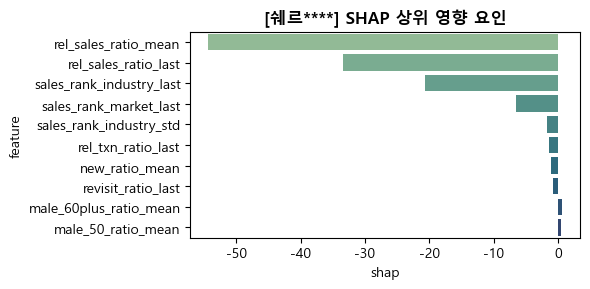

📍 쉐르**** (가맹점 49F556B92E) | 대상월 2024-10-01
예측값: 18.43 (실제 15.50) | 위험등급: 🔴 High Risk

📊 최근 3개월 추이
지난 3개월 평균(12.3) 대비 상승 추세 (Δ=+6.1)

🔍 SHAP 주요 요인
+ 긍정요인(+): 남성60+ 비중(평균), 남성50대 비중(평균), 업종내 매출 점유율(평균)
- 부정요인(–): 업종대비 매출비율(평균), 업종대비 매출비율(최근), 업종내 순위(최근)

💡 SHAP 기반 개선 솔루션
- 업종대비 매출비율(평균): 최근 3개월 평균 업종 대비 매출 비중이 낮은 상태입니다.
  ▶ 동종 업종 평균 대비 가격/품질 경쟁력을 점검하세요. / 고객 리뷰나 광고 노출을 통해 브랜드 인지도를 높이세요.
- 업종대비 매출비율(최근): 최근 업종 대비 매출 비중이 하락했습니다.
  ▶ 업종 내 상위 매장의 주요 판매 품목·가격대를 분석하세요. / 신규 메뉴 또는 시즌 한정 상품으로 관심도를 높이세요.
- 업종내 순위(최근): 최근 업종 내 매출 비중이 하락하여 경쟁력이 약화되었습니다.
  ▶ 동일 업종 내 상위 점포의 인기 상품 및 가격 정책을 벤치마킹하세요. / 리뷰 관리 및 재방문율 개선으로 업종 내 인지도를 높이세요.

💬 리뷰 수집 결과
✅ 리뷰 10건 수집 완료

🤖 AI 기반 리뷰 분석
**긍정 요인**
- 사우나의 주차장이 편리하며 3시간 무료 제공
- 마사지 서비스에 대한 긍정적인 경험 (특히 목과 어깨의 통증 완화)
- 전반적으로 무난한 시설과 가성비 좋은 서비스
- 청결한 환경 (왕십리 근처에서 가장 깨끗하다는 리뷰)

**부정 요인**
- 시설의 노후화와 관리 부족
- 직원의 친절도 부족
- 사우나의 온도 조절 문제 (물온도가 너무 뜨겁거나 미지근함)

**주요 키워드**
- 서비스: 직원 친절도, 마사지 서비스
- 가격: 가성비
- 청결: 시설 청결도
- 대기시간: 없음 (대기시간 관련 언급 없음)
- 시설: 사우나, 찜질방

**개선 솔루션 제안**
1. 직

In [22]:
sample_idx = test.sample(1, random_state=409).index[0]
result = generate_shop_report(
    idx=sample_idx,
    model=xgb_tuned,
    explainer=explainer,
    X_df=test[final_features],
    test_df=test,
    train_df=train,
    final_features=final_features,
    df_info=df_info
)

print(result["report"])


### 실행예시 2


[가게정보] 커스******* | 서울 성동구 금호로 40 . | 커피전문점
[0] 함수 시작 - address: 서울 성동구 금호로 40 ., category: 커피전문점, masked_name: 커스*******, unmasked_name: 커스
[1] Chrome 드라이버 실행 중...
[2] 검색어 입력 완료 → 서울 성동구 금호로 40 . 커피전문점 커스
[3] 검색 결과 12건 발견
[4] ✅ 일치하는 가게 찾음: 커스텀커피 금호점
[5] 상세 페이지 iframe 진입 완료
[6] 리뷰 탭 클릭 완료
[7] 스크롤 1/3 완료
[7] 스크롤 2/3 완료
[7] 스크롤 3/3 완료
[8] 리뷰 10건 수집 완료


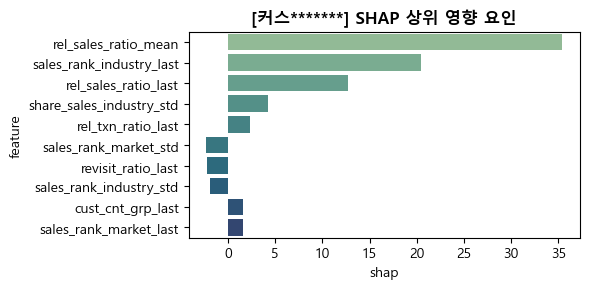

📍 커스******* (가맹점 6DF56DD3F4) | 대상월 2024-11-01
예측값: 207.00 (실제 200.50) | 위험등급: 🟢 Stable

📊 최근 3개월 추이
지난 3개월 평균(205.0) 대비 상승 추세 (Δ=+2.0)

🔍 SHAP 주요 요인
+ 긍정요인(+): 업종대비 매출비율(평균), 업종내 순위(최근), 업종대비 매출비율(최근)
- 부정요인(–): 상권내 순위 변동성, 최근 재방문율, 업종내 순위 변동성

💡 SHAP 기반 개선 솔루션
- 상권내 순위 변동성: 상권 내 매출 비중 변동성이 커져 예측이 어렵고 안정성이 낮습니다.
  ▶ 주말·평일 간 매출 편차를 줄이는 프로모션을 검토하세요. / 매출 집중 시간대에 맞춰 인력 및 재고를 최적화하세요.
- 최근 재방문율: 재방문율 하락으로 단골 고객 기반이 약화되고 있습니다.
  ▶ 단골 고객 대상 멤버십 쿠폰 또는 스탬프 이벤트를 운영하세요. / 리뷰 이벤트나 단골 전용 혜택으로 재방문을 유도하세요.
- 업종내 순위 변동성: 업종 내 매출 비중의 변동성이 커져 점유율 안정성이 낮습니다.
  ▶ 시즌별 판매 추이를 점검해 변동성이 큰 품목의 재고·가격 전략을 보완하세요. / 장기적으로는 주력 상품군을 명확히 하여 점유율을 안정화하세요.

💬 리뷰 수집 결과
✅ 리뷰 10건 수집 완료

🤖 AI 기반 리뷰 분석
**긍정 요인**
- 직원의 친절함: 여러 리뷰에서 직원들이 친절하다는 언급이 있음.
- 맛있는 음료: 특히 아이스라떼와 커피의 맛에 대한 긍정적인 평가가 많음.
- 재방문 의사: 고객들이 다시 방문하고 싶다는 의사를 표현함.

**부정 요인**
- 불친절한 서비스: 특정 직원의 불친절한 태도에 대한 부정적인 경험이 있음.
- 음료 양 부족: 아이스 음료의 양이 적다는 불만이 제기됨.

**주요 키워드**
- 서비스: 친절함, 불친절
- 맛: 커피, 아이스라떼
- 음료 양: 적음
- 재방문 의사: 긍정적

**개선 솔루션 제안**
1. **직원 교육 강화**: 친절한 서비스의 중요

In [23]:
sample_idx = test.sample(1, random_state=305).index[0]
result = generate_shop_report(
    idx=sample_idx,
    model=xgb_tuned,
    explainer=explainer,
    X_df=test[final_features],
    test_df=test,
    train_df=train,
    final_features=final_features,
    df_info=df_info
)

print(result["report"])

### 실행예시 3


[가게정보] 춘* | 서울특별시 성동구 마조로3나길 20 | 일식당
[0] 함수 시작 - address: 서울특별시 성동구 마조로3나길 20, category: 일식당, masked_name: 춘*, unmasked_name: 춘
[1] Chrome 드라이버 실행 중...
[2] 검색어 입력 완료 → 서울특별시 성동구 마조로3나길 20 일식당 춘
[3] 검색 결과 9건 발견
[4] ✅ 일치하는 가게 찾음: 춘몽
[5] 상세 페이지 iframe 진입 완료
[6] 리뷰 탭 클릭 완료
[7] 스크롤 1/3 완료
[7] 스크롤 2/3 완료
[7] 스크롤 3/3 완료
[8] 리뷰 10건 수집 완료


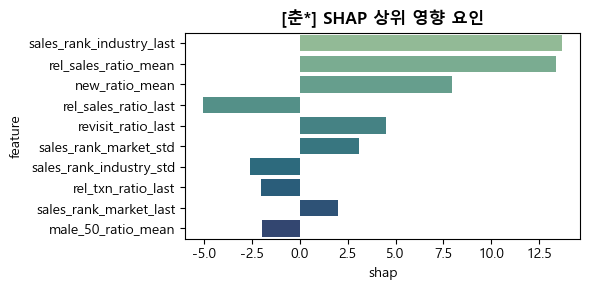

📍 춘* (가맹점 D438843206) | 대상월 2024-09-01
예측값: 172.16 (실제 141.90) | 위험등급: 🔴 High Risk

📊 최근 3개월 추이
지난 3개월 평균(192.7) 대비 하락 추세 (Δ=-20.5)

🔍 SHAP 주요 요인
+ 긍정요인(+): 업종내 순위(최근), 업종대비 매출비율(평균), 신규고객 비율
- 부정요인(–): 업종대비 매출비율(최근), 업종내 순위 변동성, 거래비율(최근)

💡 SHAP 기반 개선 솔루션
- 업종대비 매출비율(최근): 최근 업종 대비 매출 비중이 하락했습니다.
  ▶ 업종 내 상위 매장의 주요 판매 품목·가격대를 분석하세요. / 신규 메뉴 또는 시즌 한정 상품으로 관심도를 높이세요.
- 업종내 순위 변동성: 업종 내 매출 비중의 변동성이 커져 점유율 안정성이 낮습니다.
  ▶ 시즌별 판매 추이를 점검해 변동성이 큰 품목의 재고·가격 전략을 보완하세요. / 장기적으로는 주력 상품군을 명확히 하여 점유율을 안정화하세요.
- 거래비율(최근): 최근 업종 대비 거래건수 비중이 낮아 수요가 감소 중입니다.
  ▶ 시간대별 방문 데이터를 분석하고 피크 타임 집중 마케팅을 진행하세요. / 거래건수 증대를 위한 소액결제·간편구매 프로모션을 검토하세요.

💬 리뷰 수집 결과
✅ 리뷰 10건 수집 완료

🤖 AI 기반 리뷰 분석
**긍정 요인**
- 맛있는 음식: 해물 떡볶이, 주먹밥, 나가사끼짬뽕 등 다양한 메뉴의 맛이 좋다는 리뷰가 많음.
- 분위기: 편안하고 대화하기 좋은 분위기라는 긍정적인 평가.
- 친절한 서비스: 직원들이 친절하다는 언급이 있음.
- 청결: 화장실이 깨끗하다는 점이 긍정적으로 평가됨.

**부정 요인**
- 냄새 문제: 일부 리뷰에서 불쾌한 냄새가 있다는 언급이 있음.
- 양이 적음: 음식의 양이 적다는 지적이 있어, 고객이 만족하지 못할 수 있음.

**주요 키워드**
- 서비스: 친절함
- 맛: 해물 떡볶이, 주먹밥, 나가사끼짬뽕
- 분위기: 대화하기 좋은, 편안함
- 청결: 화장

In [24]:
sample_idx = test.sample(1, random_state=129).index[0]
result = generate_shop_report(
    idx=sample_idx,
    model=xgb_tuned,
    explainer=explainer,
    X_df=test[final_features],
    test_df=test,
    train_df=train,
    final_features=final_features,
    df_info=df_info
)

print(result["report"])

### 실행예시 4 -네이버 지도 미등록 매장 or 매칭 실패


[가게정보] 칠렉****** | 서울특별시 성동구 연무장길 29-1 | 식료품
[0] 함수 시작 - address: 서울특별시 성동구 연무장길 29-1, category: 식료품, masked_name: 칠렉******, unmasked_name: 칠렉
[1] Chrome 드라이버 실행 중...
[2] 검색어 입력 완료 → 서울특별시 성동구 연무장길 29-1 식료품 칠렉
[3] 검색 결과 12건 발견
❌ [FAIL] 조건에 맞는 가게를 찾지 못했습니다.


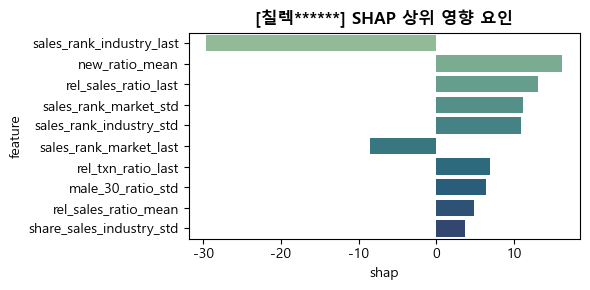

📍 칠렉****** (가맹점 B360E93D13) | 대상월 2024-09-01
예측값: 167.39 (실제 164.90) | 위험등급: 🟢 Stable

📊 최근 3개월 추이
최근 3개월 데이터 부족

🔍 SHAP 주요 요인
+ 긍정요인(+): 신규고객 비율, 업종대비 매출비율(최근), 상권내 순위 변동성
- 부정요인(–): 업종내 순위(최근), 상권내 순위(최근), 업종내 매출 점유율(평균)

💡 SHAP 기반 개선 솔루션
- 업종내 순위(최근): 최근 업종 내 매출 비중이 하락하여 경쟁력이 약화되었습니다.
  ▶ 동일 업종 내 상위 점포의 인기 상품 및 가격 정책을 벤치마킹하세요. / 리뷰 관리 및 재방문율 개선으로 업종 내 인지도를 높이세요.
- 상권내 순위(최근): 상권 내 매출 비중이 하락해 고객 유입이 감소하는 추세입니다.
  ▶ 상권 내 경쟁점의 이벤트·리뷰·운영시간을 분석해 대응 전략을 세우세요. / 주력 고객층(연령·성별)에 맞는 맞춤형 할인이나 패키지 상품을 기획하세요.
- 업종내 매출 점유율(평균): 업종 내 평균 매출 점유율이 낮아 경쟁력이 약화되고 있습니다.
  ▶ 동일 업종 내 인기 상품군을 분석해 가격·품질 경쟁력을 확보하세요. / 고객 재방문 혜택을 강화해 점유율을 높이세요.

💬 리뷰 수집 결과
❌ 리뷰 수집 실패 (상호명 불일치/검색 실패)

🤖 AI 기반 리뷰 분석
리뷰 데이터 부족으로 AI 분석 생략


In [25]:
sample_idx = test.sample(1, random_state=40).index[0]
result = generate_shop_report(
    idx=sample_idx,
    model=xgb_tuned,
    explainer=explainer,
    X_df=test[final_features],
    test_df=test,
    train_df=train,
    final_features=final_features,
    df_info=df_info
)

print(result["report"])